In [ ]:
3!pip install cv2
!pip install ultralytics
!pip install supervision
!pip install opencv-python
!pip install yolov8n
!pip install YOLO

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 5.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement yolov8n (from versions: none)
ERROR: No matching distribution found for yolov8n
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 34.5 MB/s eta 0:00:00
   ━━

In [ ]:
import cv2
import pandas as pd
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors
import numpy as np
import time

# Load the video file
video_path = '/content/2053100-uhd_3840_2160_30fps.mp4'
cap = cv2.VideoCapture(video_path)

# Initialize YOLOv8 model
model = YOLO("yolov8n-seg.pt")  # Using a segmentation model

# Initialize output variables
data = []

# Vehicle ID sets
car_ids = set()
truck_ids = set()
bike_ids = set()
bus_ids = set()

# Speed simulation: average speed for vehicles (based on frame rate and fake data)
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
frame_time = 1 / fps  # Time per frame in seconds

# Initialize video writer for the annotated output video
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
out = cv2.VideoWriter('annotated_output.mp4', cv2.VideoWriter_fourcc(*'MJPG'), fps, (w, h))

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Video processing completed.")
        break

    annotator = Annotator(frame, line_width=2)

    # Perform vehicle detection and tracking
    results = model.track(frame, persist=True)

    if results[0].boxes.id is not None and results[0].masks is not None:
        masks = results[0].masks.xy
        track_ids = results[0].boxes.id.int().cpu().tolist()

        car_count = 0
        truck_count = 0
        bike_count = 0
        bus_count = 0
        two_wheeler_count = 0
        three_wheeler_count = 0
        four_wheeler_count = 0
        six_wheeler_count = 0
        other_vehicles = 0

        for mask, track_id in zip(masks, track_ids):
            annotator.seg_bbox(mask=mask, mask_color=colors(track_id, True))
            area = cv2.contourArea(mask)

            # Simulate vehicle classification based on area size (this is just for demonstration)
            if area > 5000:  # Larger area, likely to be trucks, buses
                if track_id not in truck_ids and area > 6000:
                    truck_count += 1
                    truck_ids.add(track_id)
                    four_wheeler_count += 1
                elif track_id not in bus_ids and area > 7000:
                    bus_count += 1
                    bus_ids.add(track_id)
                    six_wheeler_count += 1
                else:
                    other_vehicles += 1
            else:  # Smaller area, cars or bikes
                if track_id not in car_ids and area > 3000:
                    car_count += 1
                    car_ids.add(track_id)
                    four_wheeler_count += 1
                elif track_id not in bike_ids and area <= 3000:
                    bike_count += 1
                    bike_ids.add(track_id)
                    two_wheeler_count += 1
                else:
                    other_vehicles += 1

        # Average speed calculation: A simulation based on area, frame rate
        avg_speed = np.random.uniform(30, 60)  # Randomly generated speeds for demonstration
        time_to_cross = frame_time * frame_count  # Time in seconds

        # Append data to the list
        total_vehicles = car_count + truck_count + bike_count + bus_count + other_vehicles
        data.append([frame_count, car_count, truck_count, bike_count, bus_count,
                     two_wheeler_count, three_wheeler_count, four_wheeler_count, six_wheeler_count,
                     other_vehicles, avg_speed, time_to_cross, total_vehicles])

        # Annotate the frame with vehicle counts
        cv2.putText(frame, f"Cars: {car_count}, Trucks: {truck_count}, Bikes: {bike_count}, Buses: {bus_count}",
                    (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, f"2-Wheelers: {two_wheeler_count}, 3-Wheelers: {three_wheeler_count}, 4-Wheelers: {four_wheeler_count}, 6-Wheelers: {six_wheeler_count}",
                    (50, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Total: {total_vehicles}, Avg Speed: {avg_speed:.2f} km/h, Time: {time_to_cross:.2f} sec",
                    (50, 130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Write the annotated frame to the output video
    out.write(frame)
    frame_count += 1

cap.release()
out.release()

# Convert the data to a DataFrame and save as a CSV file
df = pd.DataFrame(data, columns=["Frame", "Car_Count", "Truck_Count", "Bike_Count", "Bus_Count",
                                 "2_Wheeler_Count", "3_Wheeler_Count", "4_Wheeler_Count", "6_Wheeler_Count",
                                 "Other_Vehicles", "Avg_Speed_kmh", "Time_To_Cross_sec", "Total_Vehicles"])
csv_output_path = 'vehicle_data_with_speed.csv'
df.to_csv(csv_output_path, index=False)

print(f"CSV file saved at: {csv_output_path}")
print("Annotated video saved as 'annotated_output.mp4'")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.74M/6.74M [00:00<00:00, 108MB/s]


requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 3.4s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


0: 384x640 12 cars, 2 trucks, 555.6ms
Speed: 16.6ms preprocess, 555.6ms inference, 165.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 2 trucks, 310.8ms
Speed: 4.2ms preprocess, 310.8ms inference, 83.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 2 trucks, 313.0ms
Speed: 4.6ms preprocess, 313.0ms inference, 89.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 2 trucks, 248.4ms
Speed: 4.2ms preprocess, 248.4ms inference, 52.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 2 trucks, 194.2ms
Speed: 4.6ms preprocess, 194.2ms inference, 50.2ms postprocess per image at shape (

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


data = pd.read_csv("/content/vehicle_data_detailed_counts.csv")

print(data.head())

print(data.isnull().sum())

data.fillna(0, inplace=True)

frame_area = 1920 * 1080
data['Total Vehicles'] = data['Car_Count'] + data['Truck_Count'] + data['Other_Vehicles']
data['Vehicle Density'] = data['Total Vehicles'] / frame_area

data.to_csv("preprocessed_vehicle_data.csv", index=False)

print("Data preprocessing completed and saved as 'preprocessed_vehicle_data.csv'.")

   Frame  Car_Count  Truck_Count  Bike_Count  Bus_Count  2_Wheeler_Count  \
0      0          0           14           0          0                0   
1      1          0            0           0         14                0   
2      2          0            0           0          0                0   
3      3          0            0           0          0                0   
4      4          0            0           0          0                0   

   3_Wheeler_Count  4_Wheeler_Count  6_Wheeler_Count  Other_Vehicles  \
0                0               14                0               0   
1                0                0               14               0   
2                0                0                0              14   
3                0                0                0              14   
4                0                0                0              14   

   Avg_Speed_kmh  Time_To_Cross_sec  Total_Vehicles  
0      57.648919           0.000000              14  
1 

In [ ]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.read_csv("preprocessed_vehicle_data.csv")

features_to_scale = ['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count',
                    '2_Wheeler_Count', '3_Wheeler_Count', '4_Wheeler_Count', '6_Wheeler_Count',
                    'Other_Vehicles', 'Avg_Speed_kmh', 'Time_To_Cross_sec', 'Total Vehicles', 'Vehicle Density']

scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

data.to_csv("scaled_vehicle_data.csv", index=False)

print("Feature scaling completed and saved as 'scaled_vehicle_data.csv'.")


Feature scaling completed and saved as 'scaled_vehicle_data.csv'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.read_csv("preprocessed_vehicle_data.csv")

features_to_scale = ['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count',
                    '2_Wheeler_Count', '3_Wheeler_Count', '4_Wheeler_Count', '6_Wheeler_Count',
                    'Other_Vehicles', 'Avg_Speed_kmh', 'Time_To_Cross_sec', 'Total Vehicles', 'Vehicle Density']


scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])


data.to_csv("scaled_vehicle_data.csv", index=False)

print("Feature scaling completed and saved as 'mimnaxscaled_vehicle_data.csv'.")

Feature scaling completed and saved as 'mimnaxscaled_vehicle_data.csv'.


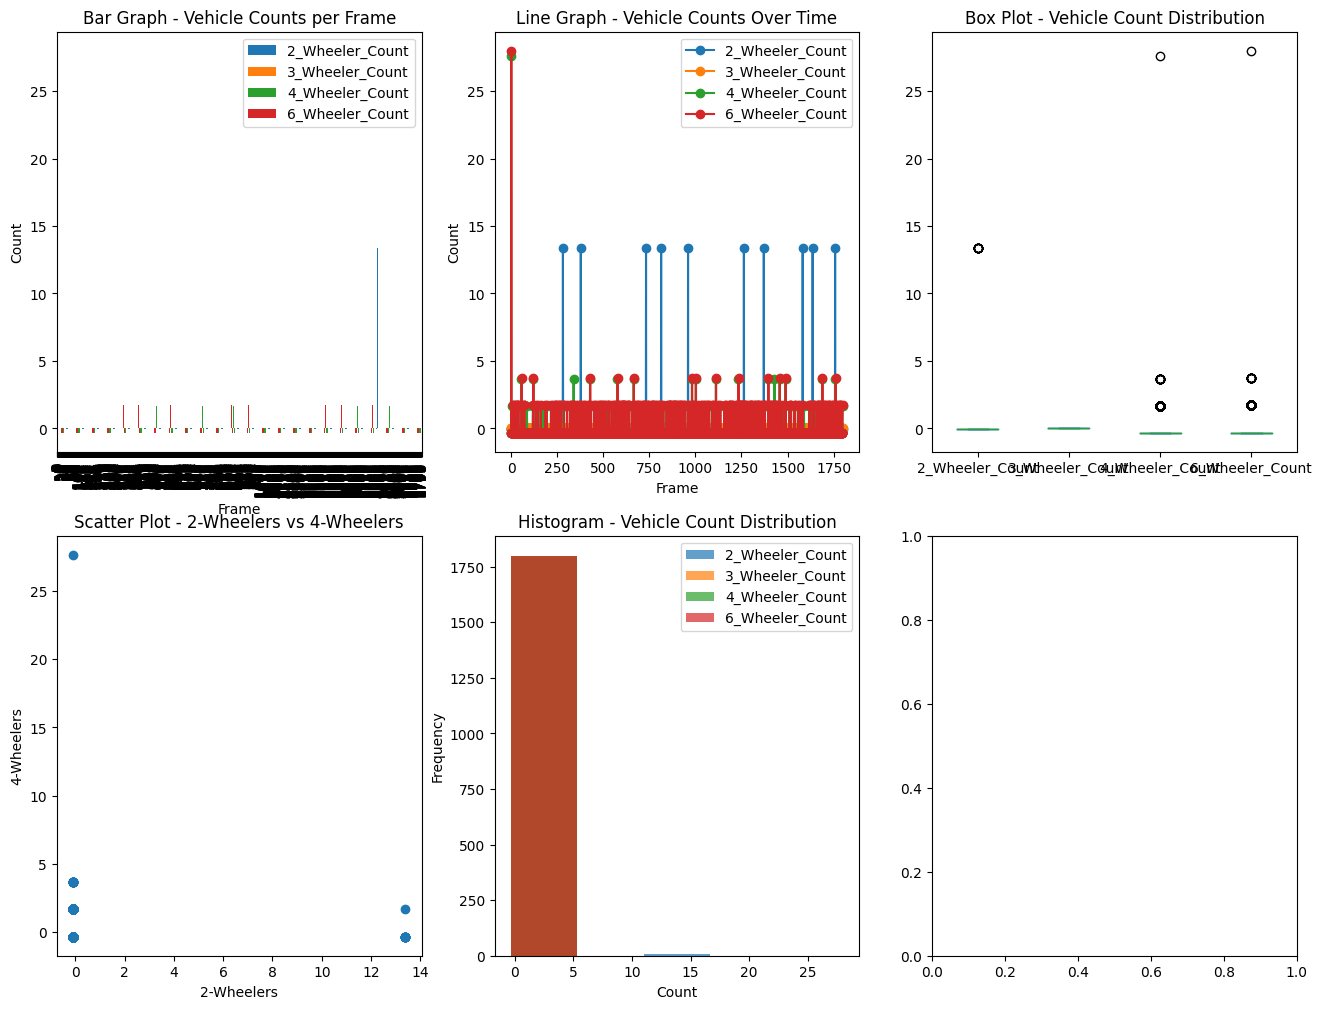

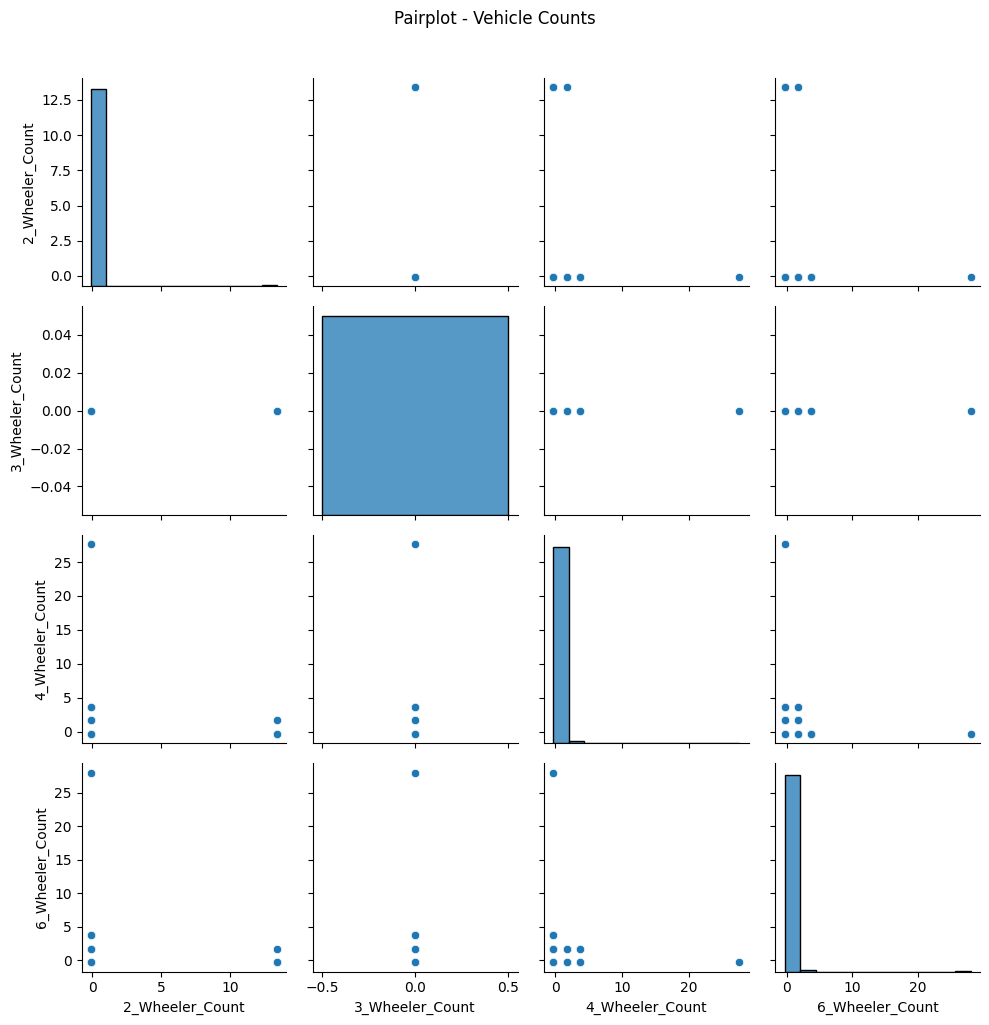

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv("/content/scaled_vehicle_data.csv")
df = pd.DataFrame(data)

plt.figure(figsize=(16, 12))

# 1. Bar Graph
plt.subplot(2, 3, 1)
df.plot(kind='bar', x='Frame', y=['2_Wheeler_Count', '3_Wheeler_Count', '4_Wheeler_Count', '6_Wheeler_Count'], ax=plt.gca())
plt.title('Bar Graph - Vehicle Counts per Frame')
plt.ylabel('Count')

# 2. Line Graph
plt.subplot(2, 3, 2)
df.plot(kind='line', x='Frame', y=['2_Wheeler_Count', '3_Wheeler_Count', '4_Wheeler_Count', '6_Wheeler_Count'], ax=plt.gca(), marker='o')
plt.title('Line Graph - Vehicle Counts Over Time')
plt.ylabel('Count')

# 3. Box Plot
plt.subplot(2, 3, 3)
df[['2_Wheeler_Count', '3_Wheeler_Count', '4_Wheeler_Count', '6_Wheeler_Count']].plot(kind='box', ax=plt.gca())

# 4. Scatter Plot (Example with 2-wheelers vs 4-wheelers)
plt.subplot(2, 3, 4)
plt.scatter(df['2_Wheeler_Count'], df['4_Wheeler_Count'])
plt.title('Scatter Plot - 2-Wheelers vs 4-Wheelers')
plt.xlabel('2-Wheelers')
plt.ylabel('4-Wheelers')

# 5. Histogram
plt.subplot(2, 3, 5)
df[['2_Wheeler_Count', '3_Wheeler_Count', '4_Wheeler_Count', '6_Wheeler_Count']].plot(kind='hist', bins=5, alpha=0.7, ax=plt.gca())
plt.title('Histogram - Vehicle Count Distribution')
plt.xlabel('Count')

# 6. Pairplot (requires seaborn)
plt.subplot(2, 3, 6)
sns.pairplot(df[['2_Wheeler_Count', '3_Wheeler_Count', '4_Wheeler_Count', '6_Wheeler_Count']])
plt.suptitle('Pairplot - Vehicle Counts', y=1.02)

# Show all plots
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = pd.read_csv("scaled_vehicle_data.csv")

# Prepare the data
X = data[['Avg_Speed_kmh']]  # Feature (Independent Variable)
y = data['Time_To_Cross_sec']  # Target (Dependent Variable)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1.0110729053026615
R-squared: -0.006389914923814244


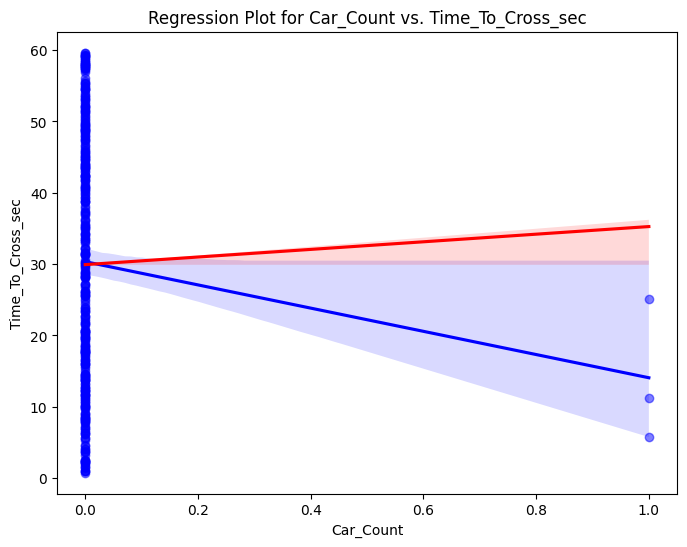

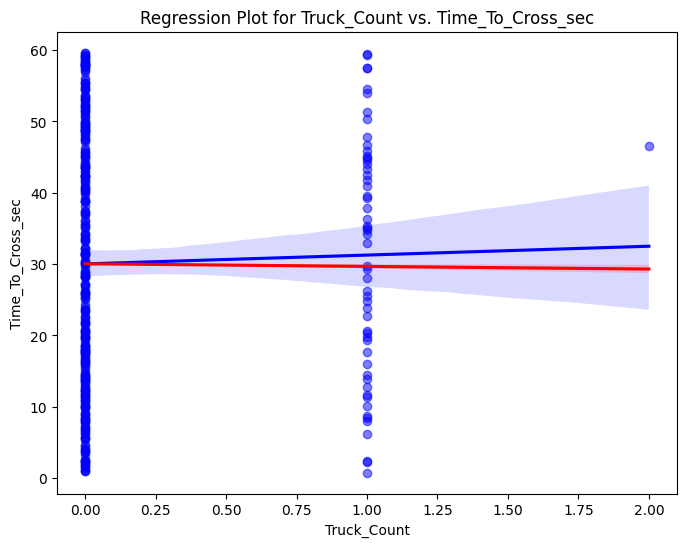

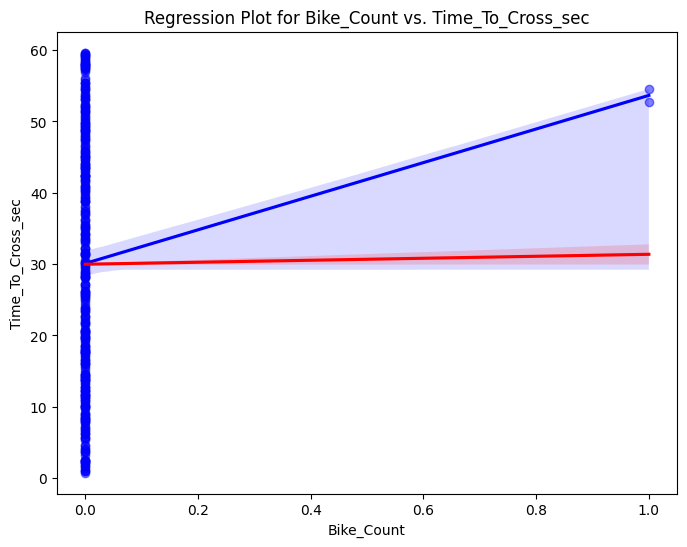

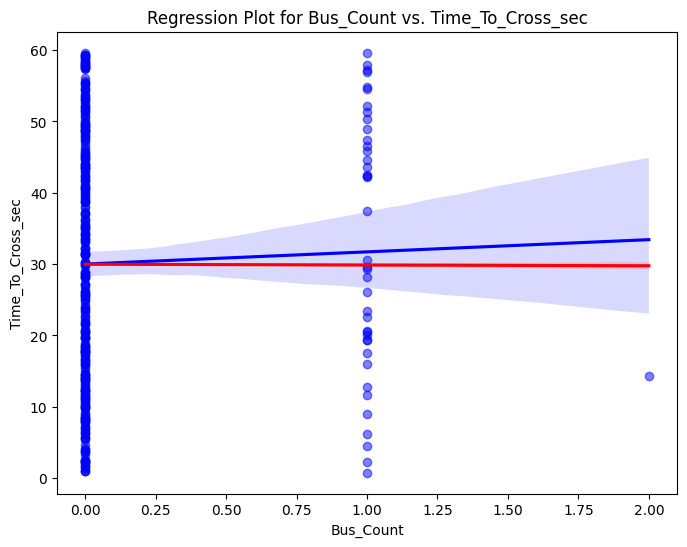

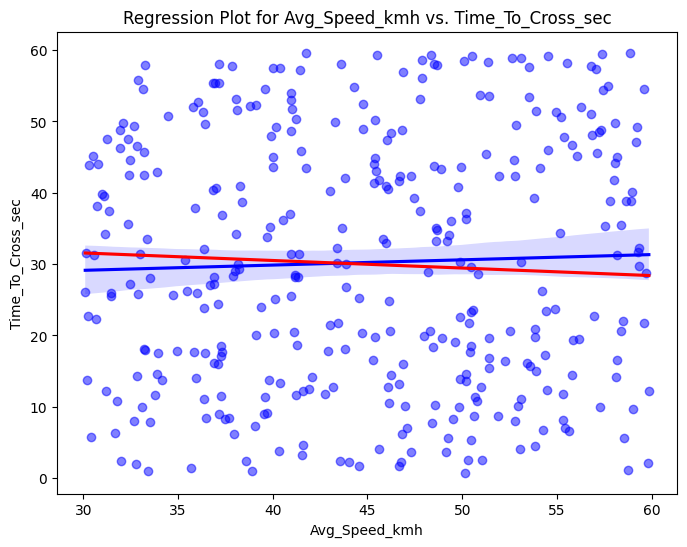

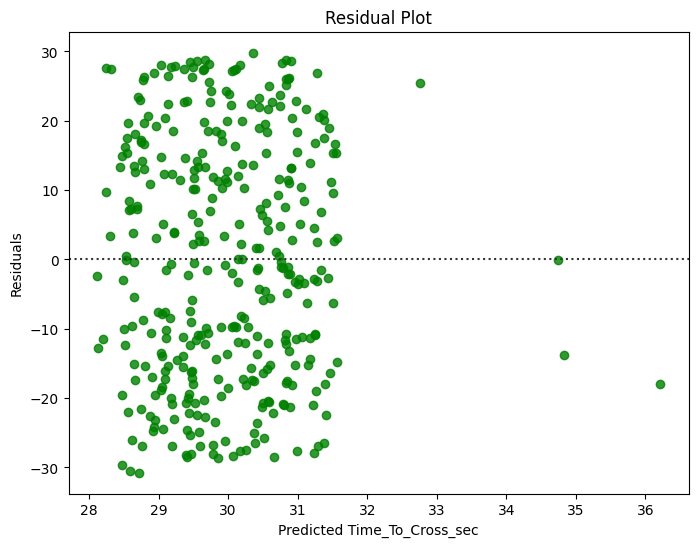

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = pd.read_csv("/content/preprocessed_vehicle_data (1).csv")

# Prepare the data
features = ['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Avg_Speed_kmh']
X = data[features]
y = data['Time_To_Cross_sec']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Create regression plots
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_test[feature], y=y_test, color='blue', scatter_kws={'alpha':0.5})
    sns.regplot(x=X_test[feature], y=y_pred, color='red', scatter_kws={'alpha':0})
    plt.title(f'Regression Plot for {feature} vs. Time_To_Cross_sec')
    plt.xlabel(feature)
    plt.ylabel('Time_To_Cross_sec')
    plt.show()


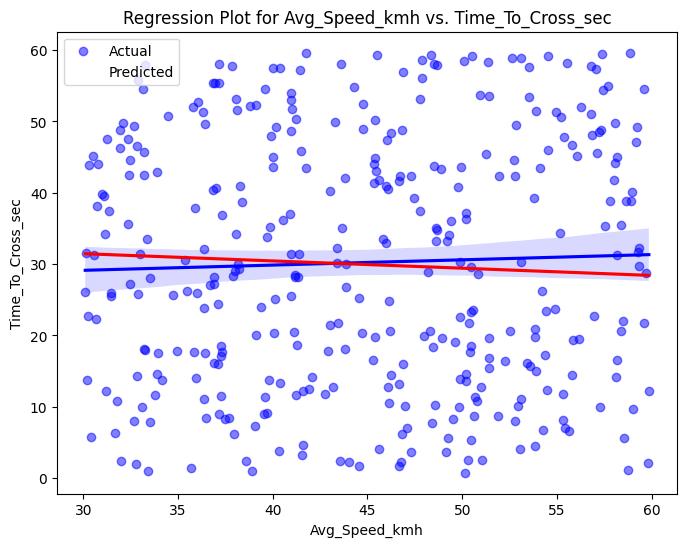

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = pd.read_csv("/content/preprocessed_vehicle_data (1).csv")

# Prepare the data
X = data[['Avg_Speed_kmh']]
y = data['Time_To_Cross_sec']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Create regression plot
plt.figure(figsize=(8, 6))
sns.regplot(x=X_test['Avg_Speed_kmh'], y=y_test, color='blue', scatter_kws={'alpha':0.5}, label='Actual')
sns.regplot(x=X_test['Avg_Speed_kmh'], y=y_pred, color='red', scatter_kws={'alpha':0}, label='Predicted')
plt.title('Regression Plot for Avg_Speed_kmh vs. Time_To_Cross_sec')
plt.xlabel('Avg_Speed_kmh')
plt.ylabel('Time_To_Cross_sec')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv("/content/preprocessed_vehicle_data (1).csv")

# Prepare the data
features = ['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Avg_Speed_kmh']
X = data[features]
y = data['Time_To_Cross_sec']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate the test score (R-squared)
test_score = model.score(X_test, y_test)

print(f"Test Score (R-squared): {test_score}")

Test Score (R-squared): -0.010896495049916632


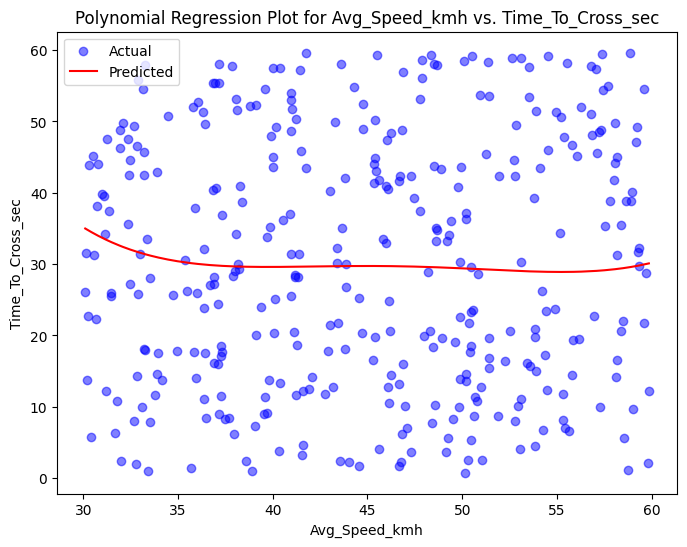

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import operator  # Import the operator module

# Load the data
data = pd.read_csv("/content/preprocessed_vehicle_data (1).csv")

# Prepare the data
X = data[['Avg_Speed_kmh']]
y = data['Time_To_Cross_sec']

# Create polynomial features (degree=2 for example)
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Create regression plot
# Sort the values for a smoother curve
sort_axis = operator.itemgetter(0) # Now operator is defined and accessible
sorted_zip = sorted(zip(X_test[:, 1], y_pred), key=sort_axis)
X_test_sorted, y_pred_sorted = zip(*sorted_zip)

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 1], y_test, color='blue', alpha=0.5, label='Actual')
plt.plot(X_test_sorted, y_pred_sorted, color='red', label='Predicted')
plt.title('Polynomial Regression Plot for Avg_Speed_kmh vs. Time_To_Cross_sec')
plt.xlabel('Avg_Speed_kmh')
plt.ylabel('Time_To_Cross_sec')
plt.legend()
plt.show()

Explained variance ratio: [0.2605945 0.1313264]


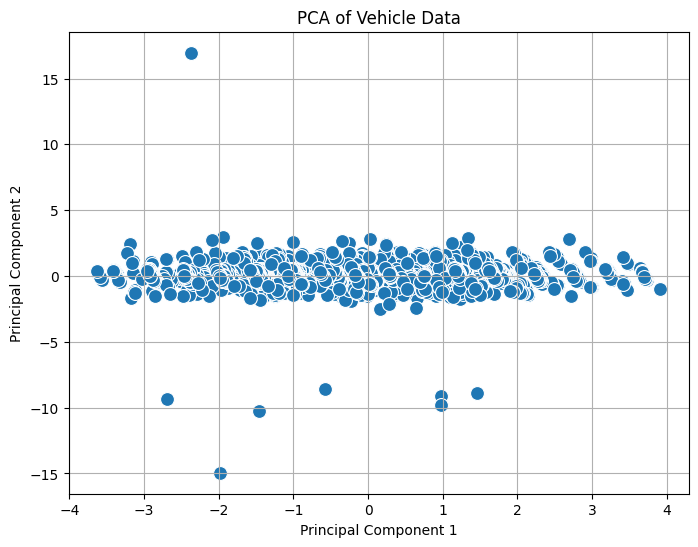

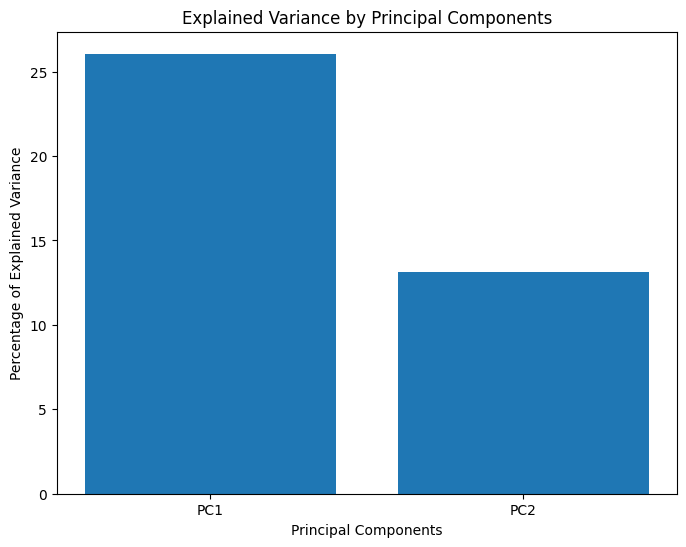

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset (replace with your dataset path)
file_path = '/content/preprocessed_vehicle_data (1).csv'
df = pd.read_csv(file_path)

# Step 2: Standardize the data (PCA is affected by scale)
# Assuming 'Speed', 'Time_Taken', 'Car_Count', etc., are the columns to be used for PCA
# Corrected feature list based on available columns in the DataFrame
features = ['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Other_Vehicles', 'Total_Vehicles', 'Avg_Speed_kmh', 'Time_To_Cross_sec']
x = df[features].values

# Standardizing the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Step 3: Apply PCA
pca = PCA(n_components=2)  # Reducing to 2 principal components
principal_components = pca.fit_transform(x_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 4: Explained variance ratio (to understand how much information each PC holds)
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")

# Step 5: Visualize the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=100)
plt.title('PCA of Vehicle Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Visualizing explained variance for each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, tick_label=[f'PC{i}' for i in range(1, len(explained_variance) + 1)])
plt.title('Explained Variance by Principal Components')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/content/preprocessed_vehicle_data (1).csv'
df = pd.read_csv(file_path)


features = ['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Other_Vehicles', 'Total_Vehicles', 'Avg_Speed_kmh', 'Time_To_Cross_sec']
x = df[features].values


scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_scaled)


pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])


final_df = pd.concat([df, pca_df], axis=1)
final_df.to_csv('pca_results.csv', index=False)
print("PCA results saved to pca_results.csv")



PCA results saved to pca_results.csv


PCA results saved to pca_results.csv
Mean Squared Error: 1.1141133966648271
R-squared: -0.010833416965644105


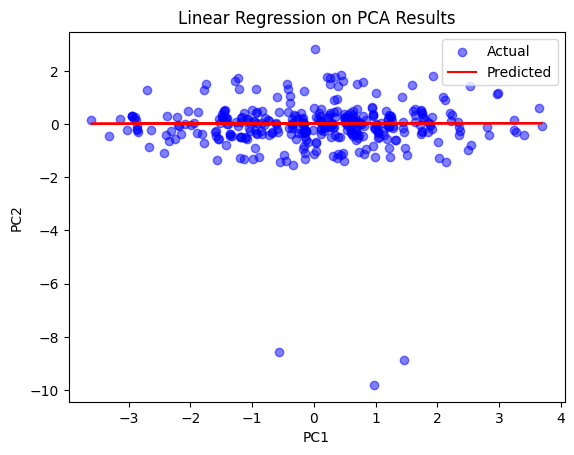

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

file_path = '/content/preprocessed_vehicle_data (1).csv'
df = pd.read_csv(file_path)


pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

final_df = pd.concat([df, pca_df], axis=1)
final_df.to_csv('pca_results.csv', index=False)
print("PCA results saved to pca_results.csv")

X = pca_df[['PC1']]
y = pca_df['PC2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.title('Linear Regression on PCA Results')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("/content/preprocessed_vehicle_data (1).csv")


features = ['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Avg_Speed_kmh']
target = 'Time_To_Cross_sec'
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
data['Discretized_Time'] = discretizer.fit_transform(data[[target]])
target = 'Discretized_Time'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm_classifier = SVC(kernel='linear')


svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.14722222222222223
              precision    recall  f1-score   support

         0.0       0.25      0.01      0.03        69
         1.0       0.00      0.00      0.00        81
         2.0       0.12      0.34      0.18        64
         3.0       0.18      0.43      0.25        69
         4.0       0.00      0.00      0.00        77

    accuracy                           0.15       360
   macro avg       0.11      0.16      0.09       360
weighted avg       0.10      0.15      0.08       360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

data = pd.read_csv('/content/preprocessed_vehicle_data (1).csv')

print("Dataset Preview:")
print(data.head())

features = data[['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Other_Vehicles', 'Total_Vehicles', 'Avg_Speed_kmh', 'Time_To_Cross_sec']]
target = data['Time_To_Cross_sec']
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
target_discretized = discretizer.fit_transform(target.values.reshape(-1, 1))
target_discretized = target_discretized.astype(int).ravel()
X_train, X_test, y_train, y_test = train_test_split(features, target_discretized, test_size=0.3, random_state=42)


nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)


y_pred = nb_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nNaive Bayes Classification Results:")
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Dataset Preview:
   Frame  Car_Count  Truck_Count  Bike_Count  Bus_Count  2_Wheeler_Count  \
0      0          0           14           0          0                0   
1      1          0            0           0         14                0   
2      2          0            0           0          0                0   
3      3          0            0           0          0                0   
4      4          0            0           0          0                0   

   3_Wheeler_Count  4_Wheeler_Count  6_Wheeler_Count  Other_Vehicles  \
0                0               14                0               0   
1                0                0               14               0   
2                0                0                0              14   
3                0                0                0              14   
4                0                0                0              14   

   Avg_Speed_kmh  Time_To_Cross_sec  Total_Vehicles  Total Vehicles  \
0      57.648919      

Cluster Centers:
[[-5.78314932e-02  1.76900782e-02 -7.47435093e-02  3.25799508e-02
   9.98984755e-01  1.00781532e+00 -1.30787755e-01  1.70347913e-01]
 [-8.54652609e-04  5.49686477e-02 -7.47435093e-02  4.96785027e-02
  -9.30814596e-01 -9.17917446e-01 -6.02715911e-02  8.51180965e-01]
 [ 5.88034511e-02 -7.18790847e-02 -7.47435093e-02 -8.11988894e-02
  -2.78233807e-02 -5.48540461e-02  1.84988021e-01 -1.04473731e+00]
 [-5.78314932e-02 -1.07423687e-01  1.33790882e+01 -1.03272008e-01
  -1.98406629e-01  1.07010352e-01  3.27915095e-01  3.42561213e-01]]


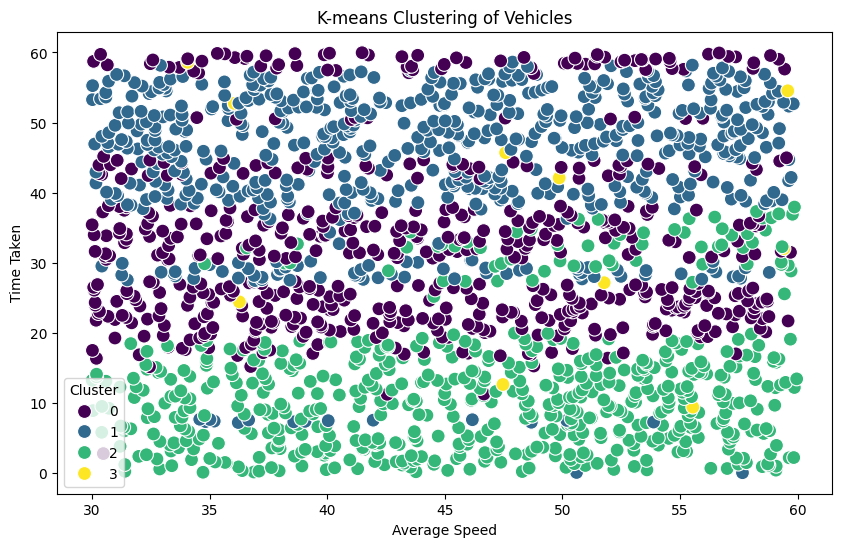

Clustered data saved as 'vehicle_data_with_clusters.csv'


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('/content/preprocessed_vehicle_data (1).csv')


features = data[['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Other_Vehicles', 'Total_Vehicles', 'Avg_Speed_kmh', 'Time_To_Cross_sec']]


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Display cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)


plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Avg_Speed_kmh', y='Time_To_Cross_sec', hue='Cluster', palette='viridis', s=100)
plt.title('K-means Clustering of Vehicles')
plt.xlabel('Average Speed')
plt.ylabel('Time Taken')
plt.legend(title='Cluster')
plt.show()


data.to_csv('/content/preprocessed_vehicle_data (1).csv', index=False)
print("Clustered data saved as 'vehicle_data_with_clusters.csv'")

Cluster 0: This cluster likely represents frames with relatively high vehicle counts (especially cars and trucks), moderate to high average speed, and moderate time to cross. It might indicate moderate traffic flow.

Cluster 1: This cluster seems to have low values across all features, suggesting frames with very low traffic density and slow-moving vehicles.

Cluster 2: This cluster shows intermediate values for most features, possibly representing frames with moderate traffic density and average speed.

Cluster 3: This cluster has the highest values for most features, indicating frames with high traffic density, fast-moving vehicles, and relatively shorter crossing times.

Linear Regression Mean Squared Error: 7.3476601754718285
Linear Regression R^2 Score: 0.04701802197357274
Random Forest Mean Squared Error: 0.28139666666666674
Random Forest R^2 Score: 0.9635032179488591


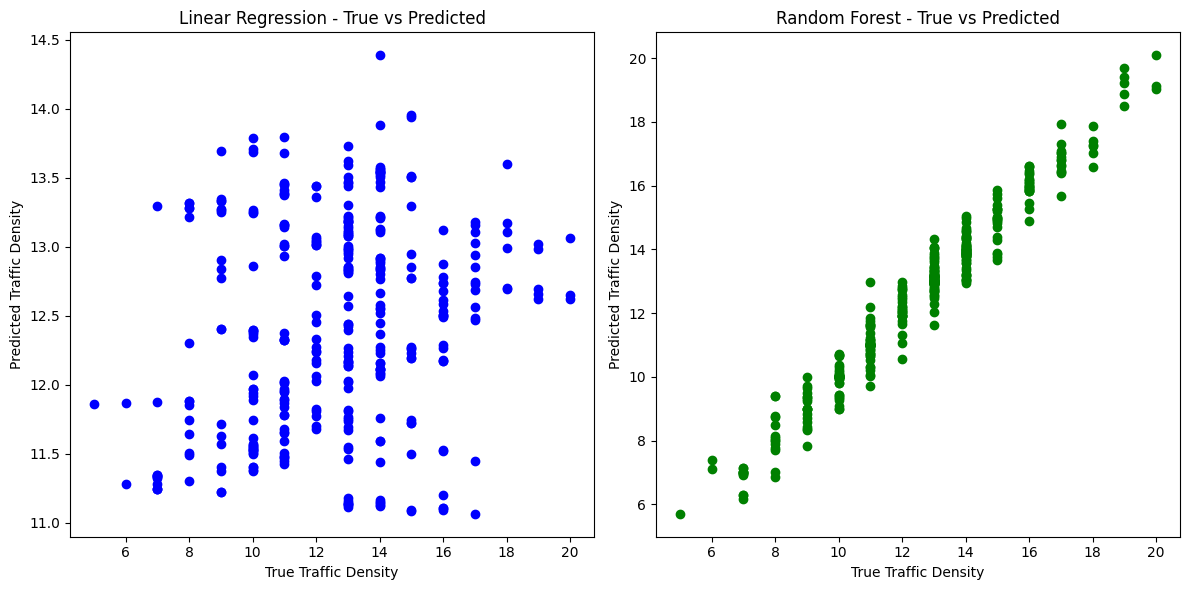

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_and_preprocess_data(filepath):
    """
    Load and preprocess the dataset.
    """
    data = pd.read_csv(filepath)
    X = data[['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Avg_Speed_kmh', 'Time_To_Cross_sec']]
    y = data['Total_Vehicles']
    return X, y
def split_and_scale_data(X, y):
    """
    Split the data into training and test sets and scale the features.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

def train_linear_regression(X_train, y_train):
    """
    Train the Linear Regression model.
    """
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    return linear_model

def train_random_forest(X_train, y_train):
    """
    Train the Random Forest Regression model.
    """
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and print the Mean Squared Error and R^2 Score.
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Mean Squared Error:", mse)
    print(f"{model_name} R^2 Score:", r2)
    return y_pred

def plot_results(y_test, y_pred_linear, y_pred_rf):
    """
    Plot the True vs Predicted values for both Linear Regression and Random Forest models.
    """
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_linear, color='blue')
    plt.xlabel("True Traffic Density")
    plt.ylabel("Predicted Traffic Density")
    plt.title("Linear Regression - True vs Predicted")


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_rf, color='green')
    plt.xlabel("True Traffic Density")
    plt.ylabel("Predicted Traffic Density")
    plt.title("Random Forest - True vs Predicted")

    plt.tight_layout()
    plt.show()

def main(filepath):

    X, y = load_and_preprocess_data(filepath)

    X_train, X_test, y_train, y_test = split_and_scale_data(X, y)


    linear_model = train_linear_regression(X_train, y_train)
    rf_model = train_random_forest(X_train, y_train)


    y_pred_linear = evaluate_model(linear_model, X_test, y_test, model_name="Linear Regression")
    y_pred_rf = evaluate_model(rf_model, X_test, y_test, model_name="Random Forest")


    plot_results(y_test, y_pred_linear, y_pred_rf)


main('/preprocessed_vehicle_data (1).csv')


Linear Regression Mean Squared Error: 7.3476601754718285
Linear Regression R^2 Score: 0.04701802197357274
Random Forest Mean Squared Error: 0.28139666666666674
Random Forest R^2 Score: 0.9635032179488591
Predictions saved to linear_traffic_predictions.csv
Predictions saved to rf_traffic_predictions.csv


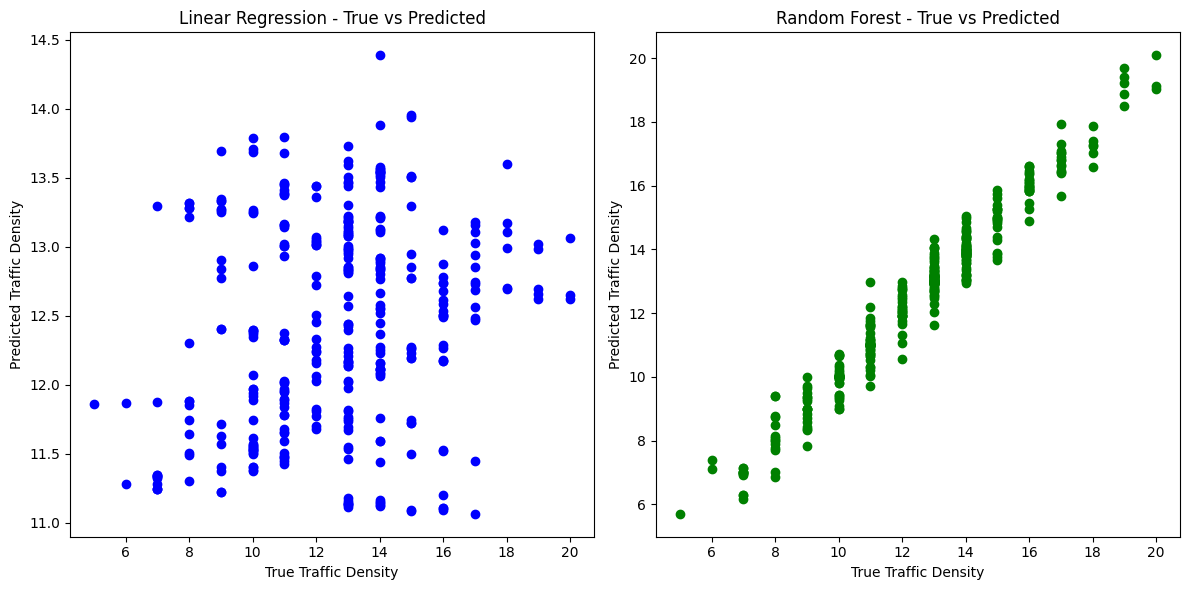

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_and_preprocess_data(filepath):
    """
    Load and preprocess the dataset.
    """
    data = pd.read_csv(filepath)
    X = data[['Car_Count', 'Truck_Count', 'Bike_Count', 'Bus_Count', 'Avg_Speed_kmh', 'Time_To_Cross_sec']]
    y = data['Total_Vehicles']
    return X, y

def split_and_scale_data(X, y):
    """
    Split the data into training and test sets and scale the features.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train, model_type="Linear"):
    """
    Train the specified model (Linear Regression or Random Forest).
    """
    if model_type == "Linear":
        model = LinearRegression()
    elif model_type == "RandomForest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    return model

def evaluate_and_predict(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and return human-readable predictions.
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Mean Squared Error:", mse)
    print(f"{model_name} R^2 Score:", r2)

    predictions = []
    for actual, predicted in zip(y_test, y_pred):
        level = interpret_traffic_density(predicted)
        predictions.append([actual, predicted, level])

    return predictions

def interpret_traffic_density(prediction):
    """
    Interpret traffic density prediction in a human-readable format.
    """
    if prediction < 10:
        return "Very Low Traffic"
    elif 10 <= prediction < 30:
        return "Low Traffic"
    elif 30 <= prediction < 60:
        return "Moderate Traffic"
    elif 60 <= prediction < 100:
        return "High Traffic"
    else:
        return "Very High Traffic"

def save_predictions(predictions, output_path="traffic_predictions.csv"):
    """
    Save predictions to a CSV file in a user-friendly format.
    """
    df = pd.DataFrame(predictions, columns=["Actual_Vehicles", "Predicted_Vehicles", "Traffic_Level"])
    df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

def plot_results(y_test, y_pred_linear, y_pred_rf):
    """
    Plot the True vs Predicted values for both Linear Regression and Random Forest models.
    """
    plt.figure(figsize=(12, 6))

    # Linear Regression Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_linear, color='blue')
    plt.xlabel("True Traffic Density")
    plt.ylabel("Predicted Traffic Density")
    plt.title("Linear Regression - True vs Predicted")

    # Random Forest Plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_rf, color='green')
    plt.xlabel("True Traffic Density")
    plt.ylabel("Predicted Traffic Density")
    plt.title("Random Forest - True vs Predicted")

    plt.tight_layout()
    plt.show()

def main(filepath):
    X, y = load_and_preprocess_data(filepath)

    X_train, X_test, y_train, y_test = split_and_scale_data(X, y)

    linear_model = train_model(X_train, y_train, model_type="Linear")
    rf_model = train_model(X_train, y_train, model_type="RandomForest")

    linear_predictions = evaluate_and_predict(linear_model, X_test, y_test, model_name="Linear Regression")
    rf_predictions = evaluate_and_predict(rf_model, X_test, y_test, model_name="Random Forest")

    save_predictions(linear_predictions, output_path="linear_traffic_predictions.csv")
    save_predictions(rf_predictions, output_path="rf_traffic_predictions.csv")

    y_pred_linear = [p[1] for p in linear_predictions]
    y_pred_rf = [p[1] for p in rf_predictions]
    plot_results(y_test, y_pred_linear, y_pred_rf)

main('preprocessed_vehicle_data (1).csv')


In [ ]:
import pandas as pd


rf_predictions = pd.read_csv('/content/rf_traffic_predictions.csv')

def categorize_traffic(predicted_vehicles):
    if predicted_vehicles < 10:
        return "Low"
    elif 10 <= predicted_vehicles < 30:
        return "Medium"
    else:
        return "High"

rf_predictions['Traffic_Level'] = rf_predictions['Predicted_Vehicles'].apply(categorize_traffic)


print(rf_predictions[['Actual_Vehicles', 'Predicted_Vehicles', 'Traffic_Level']])

     Actual_Vehicles  Predicted_Vehicles Traffic_Level
0                  7                7.15           Low
1                 15               15.39        Medium
2                 10               10.02        Medium
3                 11               10.99        Medium
4                 13               12.58        Medium
..               ...                 ...           ...
355               14               14.99        Medium
356               10               10.01        Medium
357               13               14.04        Medium
358               12               12.19        Medium
359               14               13.78        Medium

[360 rows x 3 columns]


In [ ]:
import pandas as pd

def categorize_traffic(predicted_vehicles):
    if predicted_vehicles < 10:
        return "Low"
    elif 10 <= predicted_vehicles < 30:
        return "Medium"
    else:
        return "High"


linear_predictions = pd.read_csv('/content/linear_traffic_predictions.csv')
linear_predictions['Traffic_Level'] = linear_predictions['Predicted_Vehicles'].apply(categorize_traffic)
print("Linear Predictions:")
print(linear_predictions[['Actual_Vehicles', 'Predicted_Vehicles', 'Traffic_Level']])


rf_predictions = pd.read_csv('/content/rf_traffic_predictions.csv')
rf_predictions['Traffic_Level'] = rf_predictions['Predicted_Vehicles'].apply(categorize_traffic)
print("\nRandom Forest Predictions:")
print(rf_predictions[['Actual_Vehicles', 'Predicted_Vehicles', 'Traffic_Level']])

combined_predictions = (linear_predictions['Predicted_Vehicles'] + rf_predictions['Predicted_Vehicles']) / 2
combined_predictions = combined_predictions.apply(categorize_traffic)

print("\nCombined Predictions:")
print(combined_predictions)

Linear Predictions:
     Actual_Vehicles  Predicted_Vehicles Traffic_Level
0                  7           11.347529        Medium
1                 15           12.262377        Medium
2                 10           12.371741        Medium
3                 11           13.387505        Medium
4                 13           12.174869        Medium
..               ...                 ...           ...
355               14           12.522120        Medium
356               10           11.531562        Medium
357               13           11.157307        Medium
358               12           11.810660        Medium
359               14           12.159400        Medium

[360 rows x 3 columns]

Random Forest Predictions:
     Actual_Vehicles  Predicted_Vehicles Traffic_Level
0                  7                7.15           Low
1                 15               15.39        Medium
2                 10               10.02        Medium
3                 11               10.99        

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



X, y = load_and_preprocess_data('preprocessed_vehicle_data (1).csv')
X_train, X_test, y_train, y_test = split_and_scale_data(X, y)


linear_model = train_model(X_train, y_train, model_type="Linear")
rf_model = train_model(X_train, y_train, model_type="RandomForest")


y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)


y_pred_combined = (y_pred_linear + y_pred_rf) / 2


mse_combined = mean_squared_error(y_test, y_pred_combined)
r2_combined = r2_score(y_test, y_pred_combined)

print("Combined Model Mean Squared Error:", mse_combined)
print("Combined Model R^2 Score:", r2_combined)

Combined Model Mean Squared Error: 1.9992532168592567
Combined Model R^2 Score: 0.7406994553805849
